**Exercice : Un GAN conditionnel**

Dans cet exercice, il s'agit d'implémenter un Wasserstein-GAN conditionnel. Les aspects théoriques sont laissés de côté: le but est seulement de construire la boucle d'apprentissage.\
Le contexte est le suivant: on se donne un jeu d'images représentatives d'un domaine $\mathcal{D}$.\
Le GAN classique permet de générer de nouvelles images de $\mathcal{D}$. Dans cet exercice, nous allons générer des images compatibles avec une liste de valeurs de pixels données a priori.

Les cellules suivantes permettent de visualiser le jeu disponible.

In [1]:
# Imports nécessaires
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import numpy as np

In [2]:
# Liens valable jusqu'au 17/01/2024:
# data à charger:
! wget https://www.grosfichiers.com/L7R8MLxtfzG_NwC5CzNnTSt
! tar xvf L7R8MLxtfzG_NwC5CzNnTSt
! rm L7R8MLxtfzG_NwC5CzNnTSt
# module à charger
! wget https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
! mv HAnmgiuVNGn_XtdcYCeMNnJ utile_BE.py
from utile_BE import *

--2024-01-09 14:08:19--  https://www.grosfichiers.com/L7R8MLxtfzG_NwC5CzNnTSt
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1679779840 (1.6G) [application/x-tar]
Saving to: ‘L7R8MLxtfzG_NwC5CzNnTSt’

L7R8MLxtfzG_NwC5CzN 100%[===================>]   1.56G  25.0MB/s    in 1m 51s  

2024-01-09 14:10:11 (14.4 MB/s) - ‘L7R8MLxtfzG_NwC5CzNnTSt’ saved [1679779840/1679779840]

data/
data/donut_unet_300ep_step1.pt
data/netG_180ep_WGP_scheduler75_lr005.pt
data/reid_resnet50_60ep.pt
data/tensor_test.pt
data/tensor_test_cpu.pt
data/tensor_train.pt
data/tensor_val.pt
--2024-01-09 14:10:17--  https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting 

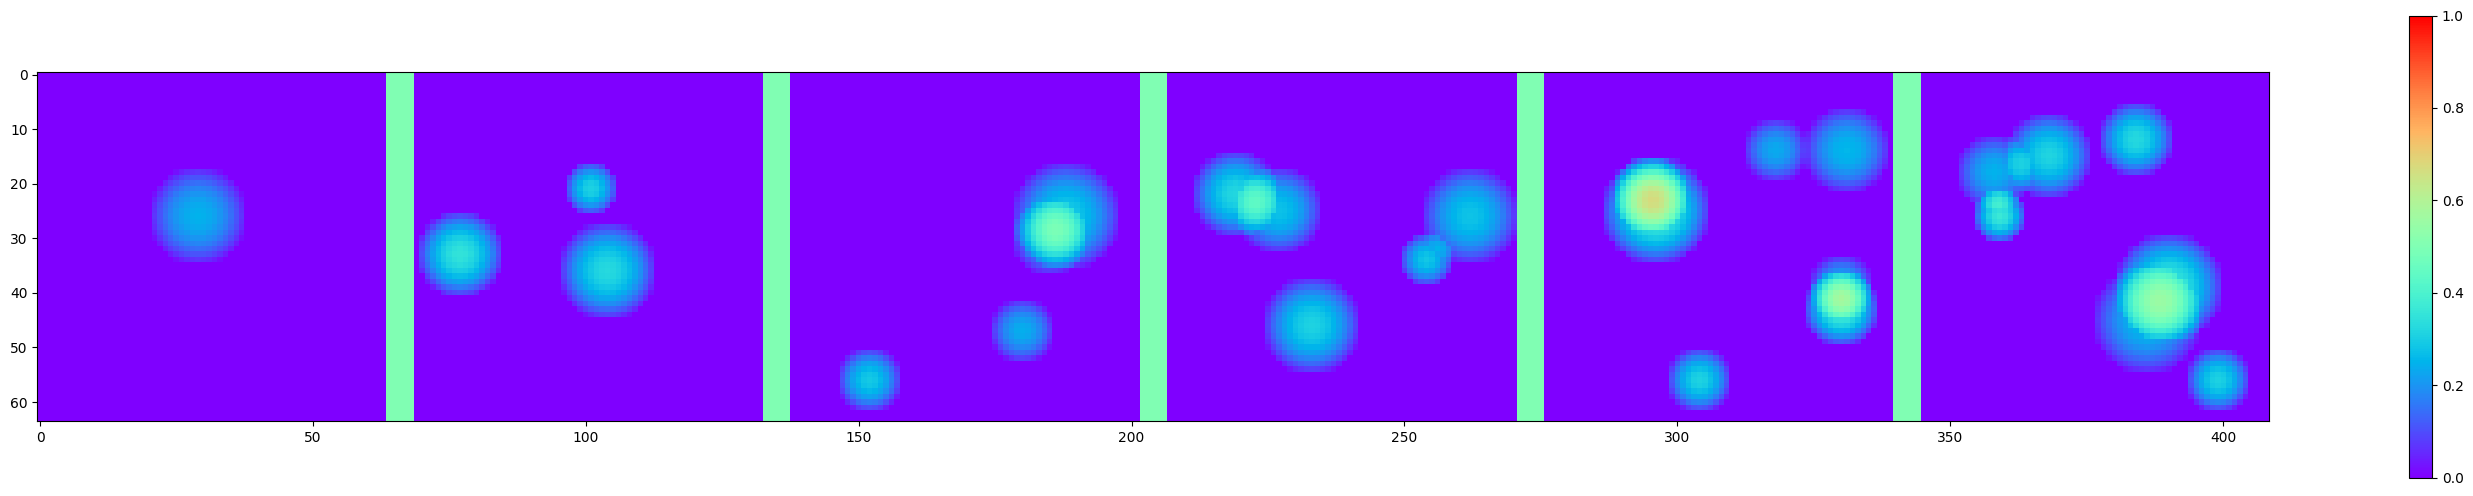

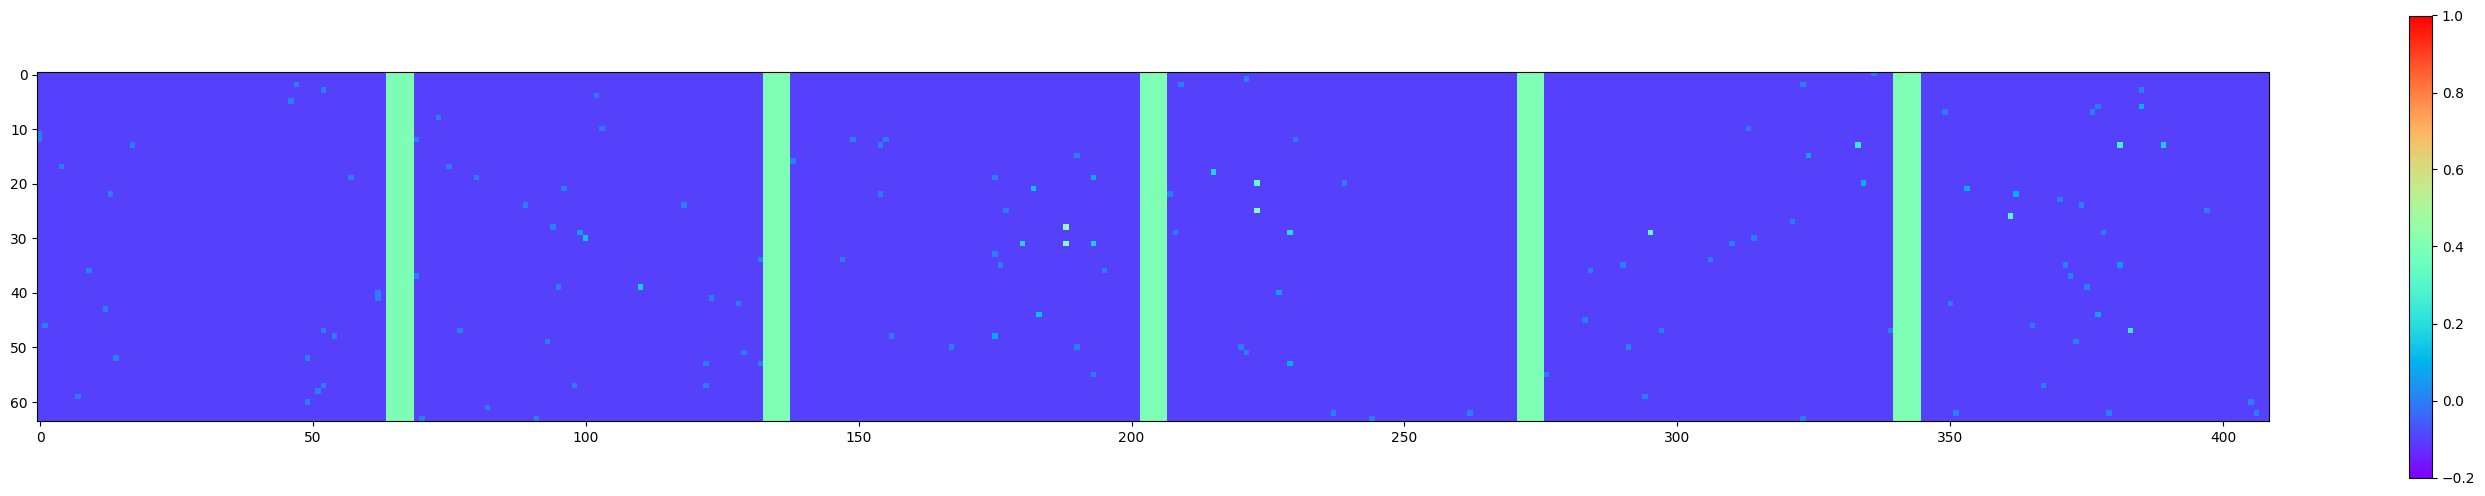

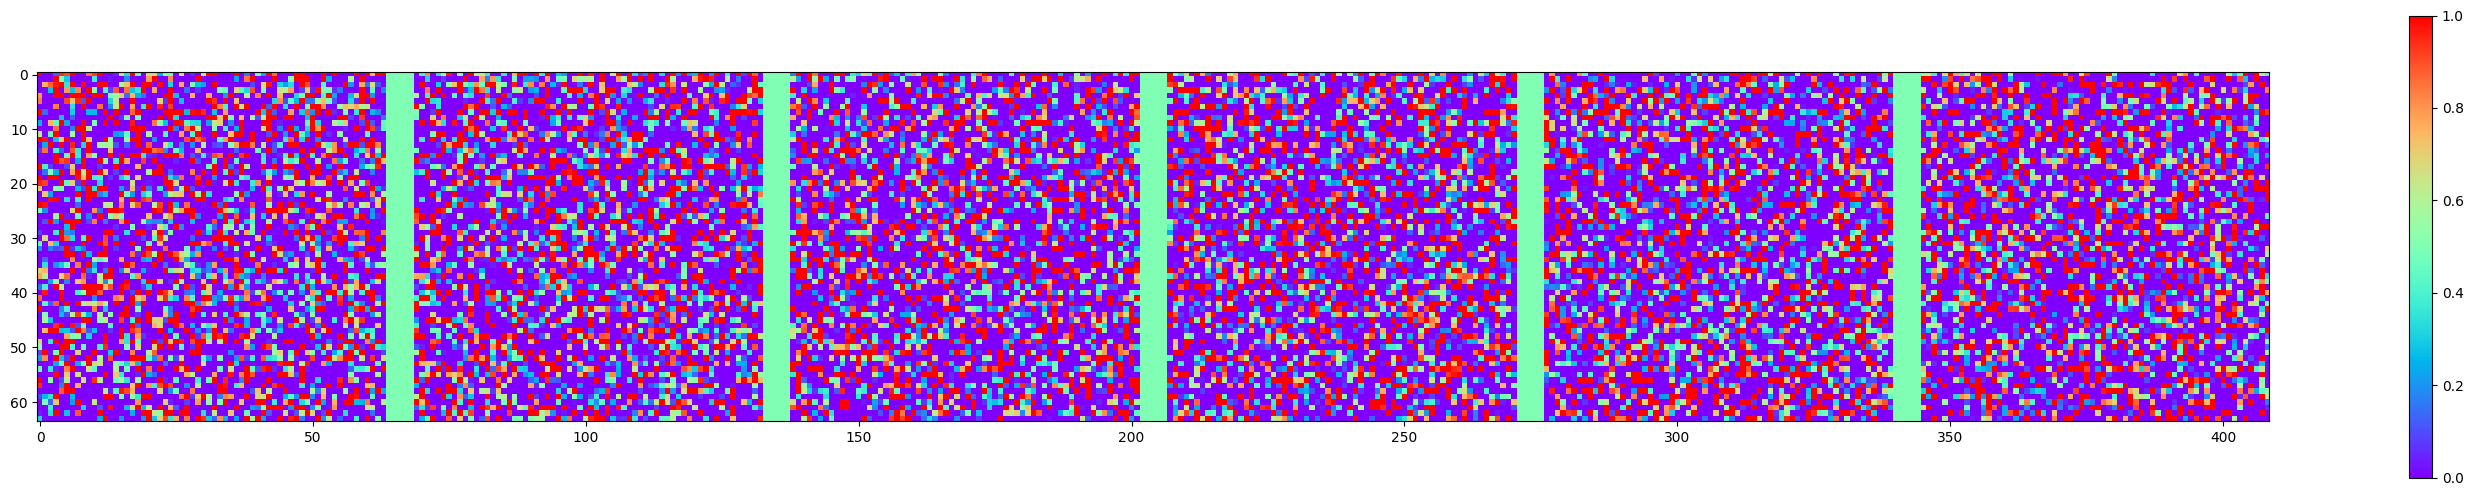

In [3]:
# proportion de pixels conservés dans yi:
dens_obs = 0.005

x , y , z = gen_condDCGAN(6,dens_obs)

# images complètes xi
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(x, 6, fig1, k=0, min_scale=0,max_scale=1)

# images fragmentaires yi: quelques pixels de xi prélevées au hasard
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(y, 6, fig2, k=0, min_scale=-0.2,max_scale=1)

# zi : échantillon d'un vecteur gaussien centré réduit
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(z, 6, fig3, k=0, min_scale=0,max_scale=1)


La première ligne contient un échantillon d'images complètes $x^i$. Ces images représente un champ scalaire à valeurs positives ou nulles.

Pour former les images framgmentaires $y^i$ (seconde ligne d'image), on a sélectionné au hasard 0.5% des pixels de chaque $x^i$, dont on a conservé les valeurs. Les valeurs de tous les autres pixels ont été fixées à -0.1.\
A considérer les $x^i$ (resp. $y^i$) comme l'échantillon d'une variable aléatoire $X$ (resp. $Y$), le but de l'exercice peut se reformuler ainsi: nous allons tenter d'échantilloner la loi $\mathcal{L}_{X|Y}$.

**Q1** Décrire brièvement le GAN classique. De combien de réseaux est-il constitué? Quels sont leur rôles respectifs ?

Le GAN classique est une méthode de deep learning permettant de générer des images relatives à une base de données. Le principe est le suivant :
On dispose de deux réseaux de neurones G et D, appelés respectivement Générateur et Discriminateur. G a pour but de générer des images qui ressemblent à celles de la base de données et D a pour objectif de différencier efficacement ces images des vraies.

**Q2** Ici, pour le générateur $G$, nous utilisons un FCN. Dans le GAN classique, les entrées sont des réalisations d'un vecteur gaussien centré réduit ($z_i$).\
Pour pouvoir prendre en compte le conditionnement par les $x_i$, $G$ doit prendre en entrée les $z_i$ et les $x_i$ (on les concaténera).\
Justifier que, de son côté, le discriminateur doit prendre en entrée les $G(x_i)$ et les $z_i$.\
Compléter la cellule suivante en conséquence.

In [4]:
nc = 2
ndf = 32

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

In [5]:
ndf = 32
n_channels = 2
n_classes = 1
size = 16

# les classes UNet et Discriminator sont codées dans utile_BE
netG = UNet(n_channels, n_classes, size).cuda()
netD = Discriminator().cuda()

**Q3** En vous inspirant de la correction du TP3, compléter la boucle d'apprentissage et la faire tourner sur dix époques:

In [6]:
# Paramétrage de la SGD
batch_size = 128
num_batches_generator = 200
num_epochs = 10

# Paramètres de l'optimizer
lr = 0.0005
beta1 = 0. # inertie de la SGD

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [7]:
real_label = 1.
fake_label = 0.

In [8]:
# Pour garder les traces des images générées à partir d'un échantillon de $z_i$ fixé:
fixed_x , fixed_y , fixed_z = gen_condDCGAN(8, p = dens_obs)

# Entrée fixe du générateur:
fixed_yz = torch.cat((fixed_y,fixed_z), dim=1).cuda()

# Listes
img_list = []
G_losses = []
D_losses = []

# Autres hyper-paramètres
n_critic = 5
clip = 0.01

In [9]:
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i in range(num_batches_generator):

        ############################
        # (1) maximisation de log(D(x)) + log(1 - D(G(z)))
        ###########################
        netG.train()
        # Ici, on procède à plusieurs (n_critic) étapes d'optimisation
        # du discriminateur.
        for j in range(n_critic):

            x , y , z = gen_condDCGAN(batch_size, p = dens_obs)

            # mise sur carte GPU
            x = x.cuda()
            y = y.cuda()
            z = z.cuda()

            netD.zero_grad()

            # concaténations :

            xy = torch.cat((x, y), dim = 1)
            yz = torch.cat((y, z), dim = 1)

            output_xy = netD(xy)

            fake = netG(yz)
            fake = fake.detach()
            fakey = torch.cat((fake,y),dim=1)
            output_fakey = netD(fakey)

            # régularisation par gradient penalty

            gradient_penalty = calculate_gradient_penalty(netD,
                                                              xy.data,
                                                              fakey.data)
            # calcul de l'erreur du discriminateur et mise à jour des gradients:
            errD = output_fakey.mean() - output_xy.mean() + 10 * gradient_penalty
            errD.backward()

            optimizerD.step()


        ############################
        # Maximisation de log(D(G(z)))
        ###########################
        netG.zero_grad()

        fake = netG(yz)
        fakey = torch.cat((fake, y), dim = 1)

        output_fakey = netD(fakey)

        errG = - output_fakey.mean()
        errG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f'
                  % (epoch+1, num_epochs, i, num_batches_generator,
                     errD.item()))

        # Enregistrement des losses
        G_losses.append(errG.item())
        D_losses.append(-errD.item())


    with torch.no_grad():
        netG.eval()
        fake = netG(fixed_yz.cuda()).detach().cpu()

    img_list.append(fake)




Starting Training Loop...
[1/10][0/200]	Loss_D: 5.2149
[1/10][50/200]	Loss_D: -3.2502
[1/10][100/200]	Loss_D: -1.8748
[1/10][150/200]	Loss_D: -1.3216
[2/10][0/200]	Loss_D: -0.1930
[2/10][50/200]	Loss_D: -0.1426
[2/10][100/200]	Loss_D: -0.5138
[2/10][150/200]	Loss_D: 0.6691
[3/10][0/200]	Loss_D: -0.8493
[3/10][50/200]	Loss_D: -0.2740
[3/10][100/200]	Loss_D: -0.0612
[3/10][150/200]	Loss_D: -0.4933
[4/10][0/200]	Loss_D: -0.5318
[4/10][50/200]	Loss_D: -0.0418
[4/10][100/200]	Loss_D: -0.3413
[4/10][150/200]	Loss_D: -0.4845
[5/10][0/200]	Loss_D: -0.1251
[5/10][50/200]	Loss_D: -0.1379
[5/10][100/200]	Loss_D: -0.4835
[5/10][150/200]	Loss_D: -0.0038
[6/10][0/200]	Loss_D: -0.0401
[6/10][50/200]	Loss_D: -0.1986
[6/10][100/200]	Loss_D: -0.2435
[6/10][150/200]	Loss_D: -0.2482
[7/10][0/200]	Loss_D: -0.2298
[7/10][50/200]	Loss_D: -0.4536
[7/10][100/200]	Loss_D: -0.2753
[7/10][150/200]	Loss_D: -0.4084
[8/10][0/200]	Loss_D: -0.1214
[8/10][50/200]	Loss_D: -0.3161
[8/10][100/200]	Loss_D: -0.0507
[8/10][1

**Q5** Visualiser quelques images et commentez.

10


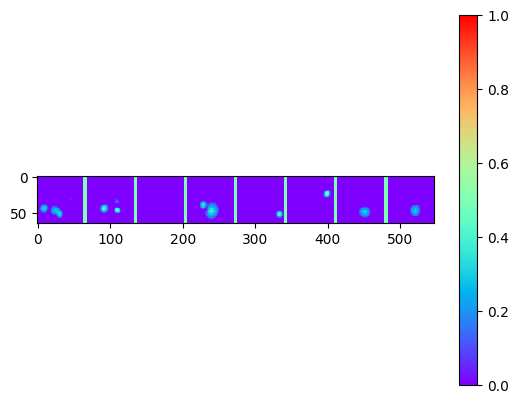

In [17]:
print(len(img_list))
voir_batch2D(img_list[-1], 8, fig1, k=0, min_scale=0,max_scale=1)

**Q6** Pour obtenir un GAN qui tienne compte de la condition contenue dans les $y_i$, il est nécessaire de pousser l'apprentissage plus loin. Le fichier *data/netG_180ep_WGP_scheduler75_lr005.pt* contient les poids obtenus après apprentissage sur 300 époques.
Charger ces poids et visualiser plusieurs images pour les mêmes entrée $x_i$ et $z_i$. Vérifier la cohérence et conclure.

In [15]:
weights = torch.load('data/netG_180ep_WGP_scheduler75_lr005.pt')
print(weights.keys())
print(netG)
netG.load_state_dict(weights['model_state_dict'])

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])
<All keys matched successfully>


AttributeError: '_IncompatibleKeys' object has no attribute 'load_state_dict'

In [12]:
netG.eval()

x , y , z = gen_condDCGAN(6, p = dens_obs)

xy = torch.cat((x, y), dim = 1)

yz = torch.cat((y, z), dim = 1)

yz = yz.cuda()

fake = netG(yz)

fakey = torch.cat((fake, y), dim = 1)

fakey = fakey.cpu().detach()

# for i in range(n):
#     _ , _ , z = gen_condDCGAN(6, p = dens_obs)

#     ...

fig1 = plt.figure(4, figsize=(36, 6))
voir_batch2D(xy, 6, fig1, k=0, min_scale=0, max_scale=1)

fig2 = plt.figure(5, figsize=(36, 6))
voir_batch2D(fakey, 6, fig1, k=0, min_scale=0, max_scale=1)


AttributeError: '_IncompatibleKeys' object has no attribute 'eval'